# Process the ERA5 Temperature and Potential Evaporation data

In this Notebook the ERA5 data is processed to be used for the wflow_sbm Geul model. The temperature data will be used, but the potential evaporation was not physically correct. This data is replaced by the potential evaporation of the KNMI Maastricht weather station.

The data is downloaded per month, so the data is first combined to one dataset. Next, the variables are renamed to their correct names. Thereafter, the variables are converted to the right units and the negative potential evaporation values are removed. Then the correct time period is selected and the data is interpolated to the coordinates of the wflow_sbm Geul model. Finally, the build dataset is downloaded.

The code is shown for the calibration period, the validation period is commented. When you want to build the validation datset, uncomment these lines and comment the lines of the calibration period.

Muñoz Sabater, J. (2019). <I>ERA5-Land hourly data from 1950 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS).</I> DOI: 10.24381/cds.e2161bac

## Import the required packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

## Define the months of interest

The data is downloaded per month. The months of the period of interest are defined in array, to make opening of the netcdfs possible

In [1]:
data_arr = ['jan2019','feb2019','mar2019','apr2019','may2019','jun2019','jul2019','aug2019','sep2019','oct2019',
           'nov2019','dec2019','jan2020','feb2020','mar2020','apr2020','may2020','jun2020','jul2020']
#data_arr = ['jul2020','aug2020','sep2020','oct2020','nov2020','dec2020','jan2021','feb2021','mar2021','apr2021','may2021',
#            'jun2021','jul2021','aug2021','sep2021','oct2021','nov2021','dec2021','jan2022','feb2022','mar2022','apr2022']
arr = []

## Open the netcdfs per month

The netcdfs of each month are openend and stored in an array

In [58]:
folder = r"C:\Users\924259\OneDrive - Royal HaskoningDHV\Documents\Master thesis Daan Idsinga\Data\Potential Evaporation and Temperature - ERA5"

In [59]:
for month in data_arr:
    arr.append(xr.open_dataset(f'{folder}\{month}.nc'))

## Merge the datasets

The datasets of each months are merged to one dataset of the period of interest

In [60]:
ds = xr.merge(arr)

In [61]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 11, latitude: 21, time: 15384)
Coordinates:
  * longitude  (longitude) float32 5.5 5.6 5.7 5.8 5.9 6.0 6.1 6.2 6.3 6.4 6.5
  * latitude   (latitude) float32 52.0 51.9 51.8 51.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 2020-07-01 ... 2022-04-02T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 289.3 289.3 ... 271.3 271.3
    pev        (time, latitude, longitude) float32 -0.005272 ... -0.003523
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-07 10:05:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Rename the variables

The variables are renamed to make them more easily accessible

In [62]:
ds = ds.rename_vars({'t2m':'temperature','pev':'potential_evaporation'})

In [63]:
ds

<xarray.Dataset>
Dimensions:                (longitude: 11, latitude: 21, time: 15384)
Coordinates:
  * longitude              (longitude) float32 5.5 5.6 5.7 5.8 ... 6.3 6.4 6.5
  * latitude               (latitude) float32 52.0 51.9 51.8 ... 50.2 50.1 50.0
  * time                   (time) datetime64[ns] 2020-07-01 ... 2022-04-02T23...
Data variables:
    temperature            (time, latitude, longitude) float32 289.3 ... 271.3
    potential_evaporation  (time, latitude, longitude) float32 -0.005272 ... ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-07 10:05:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Rename the coordinates

The names of the coordinates are renamed to same names as in the NRR dataset, to make merging of the two datasets possible

In [64]:
ds = ds.rename({'longitude':'x','latitude':'y'})

In [65]:
ds

<xarray.Dataset>
Dimensions:                (x: 11, y: 21, time: 15384)
Coordinates:
  * x                      (x) float32 5.5 5.6 5.7 5.8 5.9 ... 6.2 6.3 6.4 6.5
  * y                      (y) float32 52.0 51.9 51.8 51.7 ... 50.2 50.1 50.0
  * time                   (time) datetime64[ns] 2020-07-01 ... 2022-04-02T23...
Data variables:
    temperature            (time, y, x) float32 289.3 289.3 ... 271.3 271.3
    potential_evaporation  (time, y, x) float32 -0.005272 ... -0.003523
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-07 10:05:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Remove negative potential evaporation values and convert the unit

The potential evaporation data is given in negative values, which is changed to positive values. The remaining negative values, which is physically not possible, are replaced by zeros.

The unit of the potential evaporation is converted from meters to millimeters, as the wflow_sbm Geul model requires it.

In [66]:
ds['potential_evaporation'] = ds['potential_evaporation'] * -1
ds['potential_evaporation'] = ds.potential_evaporation*1000
ds.potential_evaporation.attrs['units'] = 'mm'

In [67]:
Meerssen = [5.725796,50.89121]
Sippenaeken = [5.940761,50.75047]

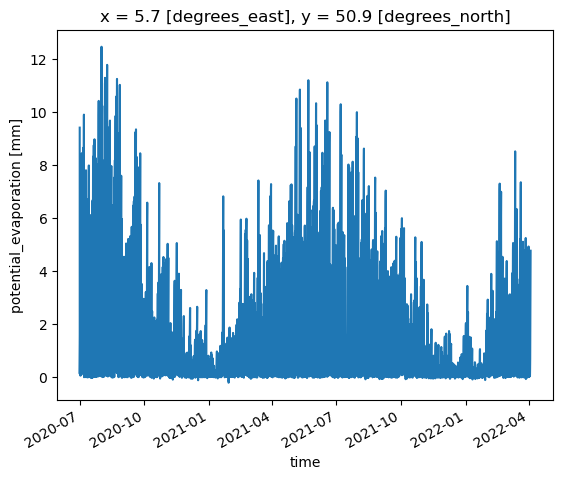

In [68]:
aa = ds.potential_evaporation.sel(x=Meerssen[0],y=Meerssen[1],method='nearest')
aa.plot()

In [69]:
variable = ds.variables['potential_evaporation']
ds['potential_evaporation'] = variable.where(variable >= 0, 0)

## Convert the temperature from Kelvin to Celsius

The temperature is converted from Kelvin to degrees Celsius as the input of the wflow_sbm Geul model should be in degrees Celsius

In [70]:
ds['temperature'] = ds.temperature - 273.15
ds.temperature.attrs['units'] = '°C'

In [71]:
ds

<xarray.Dataset>
Dimensions:                (x: 11, y: 21, time: 15384)
Coordinates:
  * x                      (x) float32 5.5 5.6 5.7 5.8 5.9 ... 6.2 6.3 6.4 6.5
  * y                      (y) float32 52.0 51.9 51.8 51.7 ... 50.2 50.1 50.0
  * time                   (time) datetime64[ns] 2020-07-01 ... 2022-04-02T23...
Data variables:
    temperature            (time, y, x) float32 16.16 16.19 ... -1.87 -1.805
    potential_evaporation  (time, y, x) float32 5.272 5.862 ... 3.914 3.523
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-07 10:05:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Check units

Check if the changed units are correct

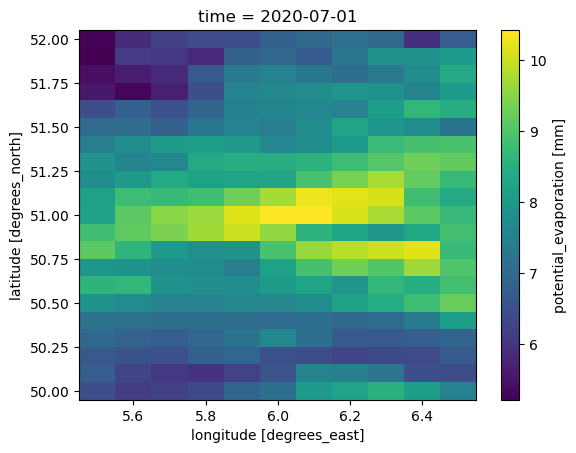

In [72]:
ds.potential_evaporation.isel(time=0).plot()

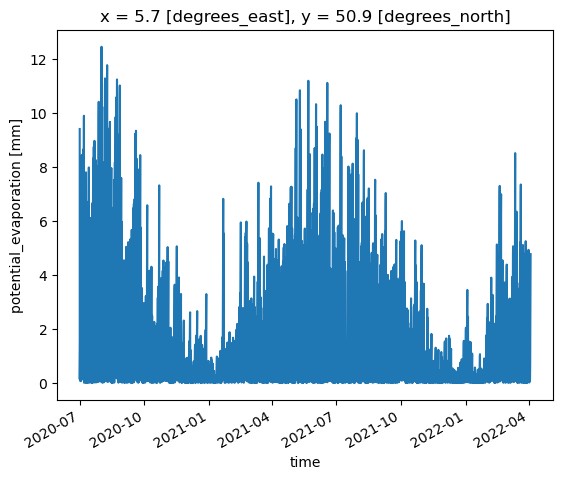

In [73]:
ds.potential_evaporation.sel(x=Meerssen[0],y=Meerssen[1],method='nearest').plot()

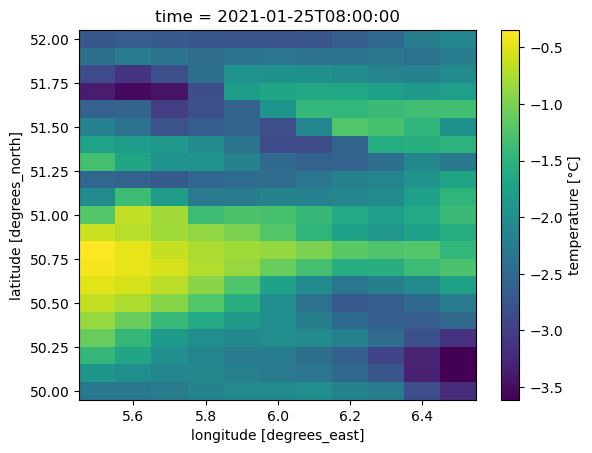

In [74]:
ds.temperature.isel(time=5000).plot()

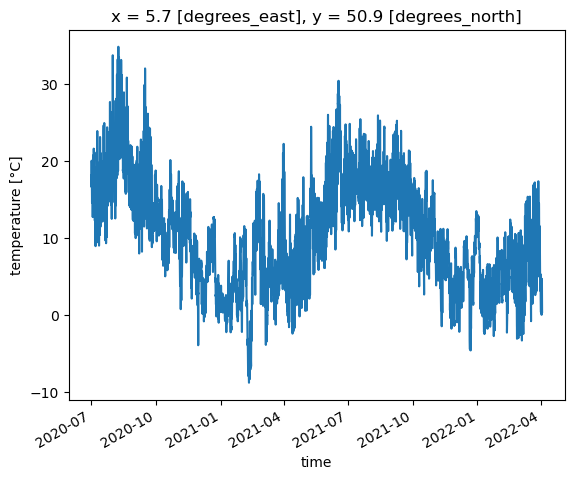

In [75]:
ds.temperature.sel(x=Meerssen[0],y=Meerssen[1],method='nearest').plot()

## Select the correct time period

The correct time period should be selected as the complete last month of the period is downloaded and only the first hour is needed. This is done for July 2020 and April 2022.

In [76]:
ds = ds.sel(time=slice('2019-01-01','2020-07-01 00:00:00'))
#ds = ds.sel(time=slice('2020-07-01','2022-04-01 00:00:00'))

In [77]:
ds

<xarray.Dataset>
Dimensions:                (x: 11, y: 21, time: 15337)
Coordinates:
  * x                      (x) float32 5.5 5.6 5.7 5.8 5.9 ... 6.2 6.3 6.4 6.5
  * y                      (y) float32 52.0 51.9 51.8 51.7 ... 50.2 50.1 50.0
  * time                   (time) datetime64[ns] 2020-07-01 ... 2022-04-01
Data variables:
    temperature            (time, y, x) float32 16.16 16.19 ... 0.9087 0.8872
    potential_evaporation  (time, y, x) float32 5.272 5.862 ... 1.386 1.272
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-07 10:05:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Save dataset

The original dataset, before the coordinates are interpolated, is downloaded and is used for potential evaporation data analysis

In [78]:
ds.to_netcdf(f'{folder}\data_calibration_org.nc')
#ds.to_netcdf(f'{folder}\data_validation_org.nc')

## Interpolate to wflow_sbm model coordinates

The coordinates of the dataset do not match the wflow_sbm Geul model coordinates and this result in a not running model. So, the coordinates are interpolated to the coordinates of the model.

In [79]:
new_latitudes = np.array([50.9175,50.909167,50.900833,50.8925,50.884167,50.875833,50.8675,50.859167,50.850833,50.8425,
                          50.834167,50.825833,50.8175,50.809167,50.800833,50.7925,50.784167,50.775833,50.7675,50.759167,
                          50.750833,50.7425,50.734167,50.725833,50.7175,50.709167,50.700833,50.6925,50.684167,50.675833,
                          50.6675,50.659167,50.650833])
new_longitudes = np.array([5.718333,5.726667,5.735,5.743333,5.751667,5.76,5.768333,5.776667,5.785,5.793333,5.801667,5.81,
                           5.818333,5.826667,5.835,5.843333,5.851667,5.86,5.868333,5.876667,5.885,5.893333,5.901667,5.91,
                           5.918333,5.926667,5.935,5.943333,5.951667,5.96,5.968333,5.976667,5.985,5.993333,6.001667,6.01,
                           6.018333,6.026667,6.035,6.043333,6.051667,6.06,6.068333,6.076667,6.085,6.093333,6.101667,6.11,
                           6.118333,6.126667])
ds_resampled = ds.interp(y=new_latitudes, x=new_longitudes)

In [80]:
ds_resampled

<xarray.Dataset>
Dimensions:                (time: 15337, y: 33, x: 50)
Coordinates:
  * time                   (time) datetime64[ns] 2020-07-01 ... 2022-04-01
  * y                      (y) float64 50.92 50.91 50.9 ... 50.67 50.66 50.65
  * x                      (x) float64 5.718 5.727 5.735 ... 6.11 6.118 6.127
Data variables:
    temperature            (time, y, x) float64 18.25 18.27 ... 0.5101 0.4943
    potential_evaporation  (time, y, x) float64 9.471 9.492 ... 1.065 1.059
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-07 10:05:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Check new coordinates

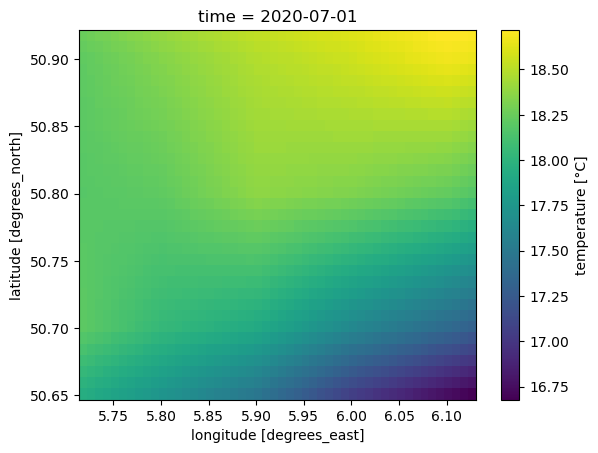

In [81]:
ds_resampled.temperature.isel(time=0).plot()

## Save the resampled dataset 

In [82]:
ds_resampled.to_netcdf(f'{folder}\data_calibration_adjusted.nc')
#ds_resampled.to_netcdf(f'{folder}\data_validation_adjusted.nc')